# Script to train a model for NMD Scanner

In [ ]:
## Train NMD efficiency Predictor upon RandomForestRegressor

recreate the train.ipynb from the NMD eff paper: https://github.com/hjkng/nmdeff/blob/main/train.ipynb

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# load dataset
df= pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset.csv')
df.shape

In [ ]:
'''
Description of columns
        downstream_exon_count (as Downstream exon count): The number of exons downstream of the PTC
        last_exon (as Last exon): 1 if the PTC is located on the last exon; 0 otherwise
        PTC_to_start_codon (as Dist PTC to start codon): The distance between the PTC to start codon
        dist_to_stop_codon (as Dist PTC to normal stop codon): The distance between the PTC and normal stop codon
        PTC_exon_length (as PTC-containing exon length): The length of the PTC-containing exon
        PTC_to_intron (as Dist PTC to downstream EJ): The distance between the PTC and downstream exon junction
        upstream_exon_count (as Upstream exon count): The number of exons upstream of the PTC
        mRNA_half_life (as mRNA half-life): The half-life of mRNA
        50nt_to_last_EJ (as Last 50nt penultimate exon): 1 if the PTC is located on the last exon; 0 otherwise
        LOEUF (as LOEUF): Gene-level degree of mutational constraints
        AF: (as Allele frequency): Allele frequency in gnomAD database
        5UTR_length: (as 5'UTR length) : The length of 5'UTR
        3UTR_length: (as 3'UTR length) : The length of 3'UTR
        Transcript_length: (as Transcript length) : The length of the transcript
'''

# we expect to match names of columns to your datasets
cols = ['downstream_exon_count', 'last_exon', 'PTC_to_start_codon',
        'dist_to_stop_codon', 'PTC_exon_length', 'PTC_to_intron','upstream_exon_count',
        'mRNA_half_life','50nt_to_last_EJ','LOEUF', 'AF', '5UTR_length', '3UTR_length', 'Transcript_length']

df[cols].head(1)

In [ ]:
df[cols].isnull().sum()

In [ ]:
df = df.loc[df['LOEUF'].notnull()].reset_index(drop=True)
df.shape

In [ ]:
regr = RandomForestRegressor(max_features = 3, n_estimators=10000, n_jobs=-1)

In [ ]:
# applying cross-valiation method for evaluation
scores = cross_val_score(regr, df[cols], df['NMD_efficiency'], cv=5)
print(f'r2: {np.mean(scores):5f}, std: {np.std(scores):5f}')

In [ ]:
X = df[cols]
y = df['NMD_efficiency']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [ ]:
regr.fit(X_train, y_train)
regr.score(X_test, y_test)
print(f'r2: {regr.score(X_test, y_test):5f}')

### Importance of trained randomforest regressor

In [ ]:
importance_df = pd.DataFrame({'feature':regr.feature_names_in_, 
                              'importance': regr.feature_importances_})

importance_df 

In [ ]:
# Save the trained model
pickle.dump(regr, open('nmd_eff_predictor', 'wb'))

### NMD efficiency

- Was genau bedeutet die Efficiency nochmal?
- Wie ist der Wertebereich?
- Hast du ein Histogramm?

In [ ]:
# Lade den TCGA Benchmark Datensatz
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset.csv')

# 1. Beschreibung der Verteilung (inkl. NaNs)
print("\n--- Beschreibung von NMD_efficiency ---")
print(df["NMD_efficiency"].describe())
print(f"Anzahl fehlender Werte: {df['NMD_efficiency'].isnull().sum()}")

# 2. Wertebereich
min_eff = df["NMD_efficiency"].min()
max_eff = df["NMD_efficiency"].max()
print(f"\nWertebereich: {min_eff:.3f} bis {max_eff:.3f}")

# 3. Histogramm anzeigen
plt.figure(figsize=(8, 5))
df["NMD_efficiency"].hist(bins=30, edgecolor='black')
plt.title("Histogramm der NMD_efficiency")
plt.xlabel("NMD_efficiency")
plt.ylabel("Anzahl")
plt.grid(False)
plt.tight_layout()
plt.show()

# Train a model for NMD Scanner

Fragen zum Model:
- Tue ich TCGA und MMRF Output joinen und gejoint als Input für mein Model oder getrennt?
- Welche Spalte ist mein y?

In [ ]:
df.shape

In [ ]:
# merge NMD_Scanner Output von TCGA mit dem NMD_efficiency score vom Original TCGA Benchmark
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset_final_nmd_results.csv')
df2 = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset.csv')

# 1. Remove transcript version number from NMD Scanner output (df)
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]

# 2. Adjust start_variant position (+1) to match TCGA coordinates
df['start_variant'] = df['start_variant'] + 1
#df['end_variant'] = df['end_variant'] - 1

# 3. Rename TCGA columns to match NMD Scanner
df2 = df2.rename(columns={
    'Transcript_ID': 'transcript_id',
    'start': 'start_variant',
    'end': 'end_variant'
})

# 4. Select only relevant columns from TCGA
df2_subset = df2[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']]

# 5. Merge
df_merged = pd.merge(df, df2_subset, on=['transcript_id', 'start_variant', 'end_variant'], how='inner')

print("Merged shape:", df_merged.shape)
print("Missing NMD_efficiency values:", df_merged['NMD_efficiency'].isnull().sum())
print(df_merged[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']].head())

In [ ]:
df_merged['NMD_efficiency'].isnull().sum()

In [ ]:
df_merged

In [ ]:
# 1. Beschreibung der Verteilung (inkl. NaNs)
print("\n--- Beschreibung von NMD_efficiency ---")
print(df_merged["NMD_efficiency"].describe())
print(f"Anzahl fehlender Werte: {df_merged['NMD_efficiency'].isnull().sum()}")

# 2. Wertebereich
min_eff = df_merged["NMD_efficiency"].min()
max_eff = df_merged["NMD_efficiency"].max()
print(f"\nWertebereich: {min_eff:.3f} bis {max_eff:.3f}")

# 3. Histogramm anzeigen
plt.figure(figsize=(8, 5))
df_merged["NMD_efficiency"].hist(bins=30, edgecolor='black')
plt.title("Histogramm der NMD_efficiency")
plt.xlabel("NMD_efficiency")
plt.ylabel("Anzahl")
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# only 9 rows missing between original TCGA dataset and joined dataset

In [ ]:
df_merged.shape

In [ ]:
# add distance to stop codon feature --> will it be a problem later on when I want to include it in AbExp?
df_merged["stop_codon_distance_nmd"] = df_merged["ref_first_stop_pos"] - df_merged["alt_first_stop_pos"]

In [ ]:
# Select the columns that we want to have as X (our features)
cols = ['start_loss', 'stop_loss', 'nmd_last_exon_rule', 'nmd_50nt_penultimate_rule', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape', # nmd escape = X or Y?
        'utr3_length', 'utr5_length', 'alt_transcript_length', 'total_exon_count', 'upstream_exon_count', 'downstream_exon_count', 'ptc_to_start_codon', 'ptc_exon_length', 
        'stop_codon_distance_nmd'] 

df_merged[cols].head(1)

In [ ]:
df_merged[cols].isnull().sum()

In [ ]:
# drop null values
df_merged = df_merged.loc[df_merged['alt_transcript_length'].notnull()].reset_index(drop=True)
df_merged = df_merged.loc[df_merged['ptc_to_start_codon'].notnull()].reset_index(drop=True)
df_merged.shape

In [ ]:
df_merged[cols].isnull().sum()

In [ ]:
df_merged.shape

In [ ]:
regr = RandomForestRegressor(max_features = 3, n_estimators=10000, n_jobs=-1)

In [ ]:
# applying cross-valiation method for evaluation
scores = cross_val_score(regr, df_merged[cols], df_merged['NMD_efficiency'], cv=5)
print(f'r2: {np.mean(scores):5f}, std: {np.std(scores):5f}')

In [ ]:
X = df_merged[cols]
y = df_merged['NMD_efficiency']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [ ]:
regr.fit(X_train, y_train)
regr.score(X_test, y_test)
print(f'r2: {regr.score(X_test, y_test):5f}')

In [ ]:
# Importance of trained randomforest regressor

In [ ]:
importance_df = pd.DataFrame({'feature':regr.feature_names_in_, 
                              'importance': regr.feature_importances_})

importance_df 

In [ ]:
# Save the trained model
pickle.dump(regr, open('nmd_eff_predictor2', 'wb'))

# Analyse der NaN Werte in df

In [ ]:
# Prüfen, ob dieselben Zeilen NaNs in allen 4 Spalten haben
mask_upstream = df["upstream_exon_count"].isnull()
mask_total = df["total_exon_count"].isnull()
mask_downstream = df["downstream_exon_count"].isnull()
mask_ptc_exon_length = df["ptc_exon_length"].isnull()

# Vergleichen, ob alle Masken identisch sind
same_rows = (
    (mask_upstream == mask_total) &
    (mask_total == mask_downstream) &
    (mask_downstream == mask_ptc_exon_length)
)

print("Alle 4 Spalten NaN in denselben Zeilen:", same_rows.all())  # Sollte True sein

In [ ]:
# Zeige nur die Zeilen mit NaNs in exon-relevanten Spalten
df[mask_total][["transcript_id", "total_exon_count", "nmd_single_exon_rule"]].head()

In [ ]:
# Bedingung: Alle vier Spalten sind NaN
mask = df[[
    "upstream_exon_count",
    "total_exon_count",
    "downstream_exon_count",
    "ptc_exon_length"
]].isnull().all(axis=1)

# Zeige alle betroffenen Zeilen (komplett)
pd.set_option("display.max_columns", None)  # Zeige alle Spalten
pd.set_option("display.max_rows", 100)      # Falls viele Zeilen, begrenze ggf.
df_nan_rows = df[mask]
df_nan_rows

In [ ]:
# check if all rows have start_loss or stop_loss = False, in that case, transcript information will be NaN

all_both_false = (df_nan_rows["start_loss"] == False) & (df_nan_rows["stop_loss"] == False)

print("Anzahl der Zeilen mit NaNs in den vier Spalten:", len(df_nan_rows))
print("Anzahl dieser Zeilen, bei denen start_loss UND stop_loss False sind:", all_both_false.sum())

# Optional: Zeige nur die Zeilen, wo das NICHT zutrifft (zur Kontrolle)
df_nan_rows[~all_both_false]

In [ ]:
# check if alt_is_premature = FALSE in all cases
all_false = (df_nan_rows["alt_is_premature"] == False).all()
print("alt_is_premature überall False:", all_false)

In [ ]:
# Wahrscheinlich kommen die 217 Null-Werte in total_exon_count, downstream_exon_count, upstream_exon_count und ptc_exon_length daher, dass alt_is_premature = False ist. 
# Jetzt will ich mir die anderen columns mit den Null Werten anschauen. Dafür extrahiere ich alle Zeilen wo alt_transcript_length = NaN da hier die höchste Zahl ist, und schaue nach,
# ob die anderen NaN Werte hier drin enthalten sind.

In [ ]:
df[cols].isnull().sum()

In [ ]:
# check if ptc_to_start_codon = NaN is because we do not have a PTC

# Check, ob ptc_to_start_codon NaN ist, weil kein PTC vorhanden ist
ptcstartcodon_df = df["ptc_to_start_codon"].isnull()
df_na = df[ptcstartcodon_df].copy()

# Überprüfen, ob überall alt_is_premature == False
all_false = (df_na["alt_is_premature"] == False).all()
print("alt_is_premature überall False:", all_false)

# Zähle wie oft False bzw. True vorkommt
value_counts = df_na["alt_is_premature"].value_counts(dropna=False)
print("\nVerteilung von alt_is_premature bei fehlendem ptc_to_start_codon:")
print(value_counts)

In [ ]:
# Maske für Zeilen mit NaN in alt_transcript_length
mask_alt_transcript_na = df["alt_transcript_length"].isnull()

# Neues DataFrame mit diesen 1854 Zeilen
df_alt_na = df[mask_alt_transcript_na].copy()

# Anzahl dieser Zeilen (sollte 1854 sein)
print("Anzahl Zeilen mit alt_transcript_length NaN:", df_alt_na.shape[0])

# Prüfen, wie viele davon auch andere Spalten als NaN haben
null_counts_in_alt_na = df_alt_na[[
    "total_exon_count",
    "upstream_exon_count",
    "downstream_exon_count",
    "ptc_exon_length",
    "ptc_to_start_codon",
    "stop_codon_distance_nmd"
]].isnull().sum()

print("NaN-Werte innerhalb der 1854 alt_transcript_length-NaNs:")
print(null_counts_in_alt_na)

# Wie viele der 1854 haben alt_is_premature == False?
false_premature_count = df_alt_na["alt_is_premature"] == False
print("Anzahl alt_is_premature == False innerhalb der 1854:", false_premature_count.sum())

In [ ]:
# Grund für alt_transcript_length = NaN ist weil cds_in_transcript = False ist, d.h. das CDS konnte nicht im Transkript festgestellt werden

# Anzahl der Fälle, in denen cds_in_transcript == False
cds_false_count = df[df["cds_in_transcript"] == False].shape[0]

# Anzahl der Fälle, in denen alt_transcript_length == NaN
alt_len_nan_count = df["alt_transcript_length"].isnull().sum()

# Anzahl der Fälle, in denen cds_in_transcript == False und alt_transcript_length == NaN
both_condition_count = df[(df["cds_in_transcript"] == False) & (df["alt_transcript_length"].isnull())].shape[0]

print(f"cds_in_transcript == False: {cds_false_count}")
print(f"alt_transcript_length == NaN: {alt_len_nan_count}")
print(f"Beides gleichzeitig: {both_condition_count}")
print(f"Vollständige Übereinstimmung: {cds_false_count == alt_len_nan_count == both_condition_count}")

# Create my own Model

In [2]:
# merge NMD_Scanner Output von TCGA mit dem NMD_efficiency score vom Original TCGA Benchmark
df = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset_final_nmd_results.csv')
df2 = pd.read_csv('~/NMD/nmd-variant-effect-prediction/resources/TCGA_benchmark/tcga_dataset.csv')

# 1. Remove transcript version number from NMD Scanner output (df)
df['transcript_id'] = df['transcript_id'].str.split('.').str[0]

# 2. Adjust start_variant position (+1) to match TCGA coordinates
df['start_variant'] = df['start_variant'] + 1
#df['end_variant'] = df['end_variant'] - 1

# 3. Rename TCGA columns to match NMD Scanner
df2 = df2.rename(columns={
    'Transcript_ID': 'transcript_id',
    'start': 'start_variant',
    'end': 'end_variant'
})

# 4. Select only relevant columns from TCGA
df2_subset = df2[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']]

# 5. Merge
df_merged = pd.merge(df, df2_subset, on=['transcript_id', 'start_variant', 'end_variant'], how='inner')

# 6. add distance to stop codon feature --> will it be a problem later on when I want to include it in AbExp?
df_merged["stop_codon_distance_nmd"] = df_merged["ref_first_stop_pos"] - df_merged["alt_first_stop_pos"]

# Select the columns that we want to have as X (our features)
cols = ['start_loss', 'stop_loss', 'nmd_last_exon_rule', 'nmd_50nt_penultimate_rule', 'nmd_long_exon_rule', 'nmd_start_proximal_rule', 'nmd_single_exon_rule', 'nmd_escape', # nmd escape = X or Y?
        'utr3_length', 'utr5_length', 'alt_transcript_length', 'total_exon_count', 'upstream_exon_count', 'downstream_exon_count', 'ptc_to_start_codon', 'ptc_exon_length', 
        'stop_codon_distance_nmd'] 

# drop null values --> LightGBM can handle this
#df_merged = df_merged.loc[df_merged['alt_transcript_length'].notnull()].reset_index(drop=True)
#df_merged = df_merged.loc[df_merged['ptc_to_start_codon'].notnull()].reset_index(drop=True)

X = df_merged[cols]
y = df_merged['NMD_efficiency']

print("Merged shape:", df_merged.shape)
print("Missing NMD_efficiency values:", df_merged['NMD_efficiency'].isnull().sum())
print(df_merged[['transcript_id', 'start_variant', 'end_variant', 'NMD_efficiency']].head())

Merged shape: (4246, 73)
Missing NMD_efficiency values: 0
     transcript_id  start_variant  end_variant  NMD_efficiency
0  ENST00000000412        8942472      8942472        0.389934
1  ENST00000000442       64314869     64314869        0.425091
2  ENST00000002165      143497446    143497446        1.165452
3  ENST00000002829       50174085     50174085        1.631418
4  ENST00000003084      117627525    117627525        0.999051


In [12]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df_merged[cols].isnull().sum()

start_loss                    0
stop_loss                     0
nmd_last_exon_rule            0
nmd_50nt_penultimate_rule     0
nmd_long_exon_rule            0
nmd_start_proximal_rule       0
nmd_single_exon_rule          0
nmd_escape                    0
utr3_length                   0
utr5_length                   0
alt_transcript_length        10
total_exon_count              0
upstream_exon_count           0
downstream_exon_count         0
ptc_to_start_codon            3
ptc_exon_length               0
stop_codon_distance_nmd      10
dtype: int64

In [10]:
# First try models who can handle NaN values
models = {
    "Random Forest": RandomForestRegressor(n_estimators=500, max_features=3),
    "XGBoost": xgb.XGBRegressor(n_estimators=500, learning_rate=0.05),
    "LightGBM": LGBMRegressor(n_estimators=500),
}

print("Model Comparison (5-fold CV, R² Scores):")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"{name:15s} | R²: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

Model Comparison (5-fold CV, R² Scores):
Random Forest   | R²: 0.3220 ± 0.0305
XGBoost         | R²: 0.2652 ± 0.0246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1696
[LightGBM] [Info] Number of data points in the train set: 3396, number of used features: 13
[LightGBM] [Info] Start training from score 0.980825
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1696
[LightGBM] [Info] Number of data points in the train set: 3397, number of used features: 13
[LightGBM] [Info] Start training from score 1.011646
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1694
[Ligh

In [13]:
# Try imputation for models which can't handle NaN values

nan_sensitive_models = {
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=500),
    "Ridge": Ridge(),
    "Lasso": Lasso(alpha=0.01),
    "SVR": SVR()
}

# Evaluate models that need NaNs removed or imputed
print("\nModels that need NaNs handled:")

# Create imputation pipeline (mean imputation as a start)
imputer = SimpleImputer(strategy='mean')

for name, model in nan_sensitive_models.items():
    pipe = Pipeline([
        ('imputer', imputer),
        ('model', model)
    ])
    scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')
    print(f"{name:20s} | R²: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

Models that support NaNs directly:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1696
[LightGBM] [Info] Number of data points in the train set: 3396, number of used features: 13
[LightGBM] [Info] Start training from score 0.980825
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1696
[LightGBM] [Info] Number of data points in the train set: 3397, number of used features: 13
[LightGBM] [Info] Start training from score 1.011646
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1694
[LightGBM] [Info] Number of data points in the train set: 3397, number of used features

/opt/modules/i12g/anaconda/envs/NMD_test/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.641e+02, tolerance: 5.446e-01
  model = cd_fast.enet_coordinate_descent(
/opt/modules/i12g/anaconda/envs/NMD_test/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.750e+02, tolerance: 5.479e-01
  model = cd_fast.enet_coordinate_descent(
/opt/modules/i12g/anaconda/envs/NMD_test/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

SVR                  | R²: 0.1748 ± 0.0205


In [15]:
df_merged[cols].isnull().sum()

start_loss                    0
stop_loss                     0
nmd_last_exon_rule            0
nmd_50nt_penultimate_rule     0
nmd_long_exon_rule            0
nmd_start_proximal_rule       0
nmd_single_exon_rule          0
nmd_escape                    0
utr3_length                   0
utr5_length                   0
alt_transcript_length        10
total_exon_count              0
upstream_exon_count           0
downstream_exon_count         0
ptc_to_start_codon            3
ptc_exon_length               0
stop_codon_distance_nmd      10
dtype: int64

In [21]:
# Now remove NaN values
df_merged = df_merged.loc[df_merged['alt_transcript_length'].notnull()].reset_index(drop=True)
df_merged = df_merged.loc[df_merged['ptc_to_start_codon'].notnull()].reset_index(drop=True)
df_merged[cols].isnull().sum()

X = df_merged[cols]
y = df_merged['NMD_efficiency']

In [22]:
# Try different models --> some accept NaNs some not
models = {
    "Random Forest": RandomForestRegressor(n_estimators=500, max_features=3),
    "XGBoost": xgb.XGBRegressor(n_estimators=500, learning_rate=0.05),
    "LightGBM": LGBMRegressor(n_estimators=500),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=500),    
    "Ridge": Ridge(),
    "Lasso": Lasso(alpha=0.01),
    "SVR": SVR()
}

print("Model Comparison (5-fold CV, R² Scores):")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"{name:15s} | R²: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

Model Comparison (5-fold CV, R² Scores):
Random Forest   | R²: 0.3235 ± 0.0271
XGBoost         | R²: 0.2687 ± 0.0234
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1695
[LightGBM] [Info] Number of data points in the train set: 3386, number of used features: 13
[LightGBM] [Info] Start training from score 0.979387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1695
[LightGBM] [Info] Number of data points in the train set: 3386, number of used features: 13
[LightGBM] [Info] Start training from score 1.009992
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1694
[Ligh

/opt/modules/i12g/anaconda/envs/NMD_test/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e+03, tolerance: 5.288e-01
  model = cd_fast.enet_coordinate_descent(
/opt/modules/i12g/anaconda/envs/NMD_test/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.362e+03, tolerance: 5.414e-01
  model = cd_fast.enet_coordinate_descent(
/opt/modules/i12g/anaconda/envs/NMD_test/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

SVR             | R²: 0.1755 ± 0.0217


In [33]:
# make sure no NaNs for this model since it had best R2-score
df_merged[cols].isnull().sum()

start_loss                   0
stop_loss                    0
nmd_last_exon_rule           0
nmd_50nt_penultimate_rule    0
nmd_long_exon_rule           0
nmd_start_proximal_rule      0
nmd_single_exon_rule         0
nmd_escape                   0
utr3_length                  0
utr5_length                  0
alt_transcript_length        0
total_exon_count             0
upstream_exon_count          0
downstream_exon_count        0
ptc_to_start_codon           0
ptc_exon_length              0
stop_codon_distance_nmd      0
dtype: int64

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import numpy as np

# Define X and y from your earlier code
X = df_merged[cols]
y = df_merged['NMD_efficiency']

# Try doing Grid-Search
param_grid = {
    'n_estimators': [100, 300, 500], #
    'max_depth': [None, 3, 5, 10],
    'max_features': ['sqrt', 0.3, 0.5], #
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2], #
    # 'criterion': ['gini', 'entropy']
}

refined_grid = {
    'n_estimators': [250, 300, 350],
    'max_depth': [8, 10, 12],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3]
}

refined_grid2 = {
    'n_estimators': [230, 250, 270],
    'max_depth': [10, 11, 12],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

refined_grid3 = {
    'n_estimators': [100, 150, 200, 230, 250],
    'max_depth': [10],
    'max_features': ['sqrt'],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 2]
}

regr = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=regr,
    param_grid=refined_grid3, # param_grid
    scoring='r2',
    cv=5,
    verbose=2, # Shows progress in terminal
    n_jobs=-1 # Use all cores
)

grid_search.fit(X, y)

print("\nBest Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 230}
Best R² Score: 0.3321846749577757


In [45]:
# save best Random Forest model
best_rf = grid_search.best_estimator_

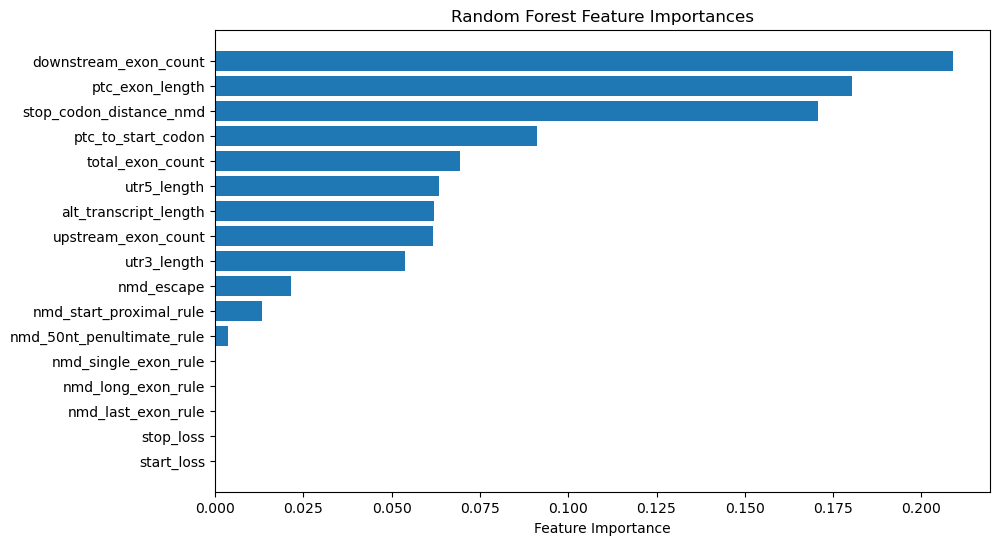

In [46]:
# Feature Importance

import matplotlib.pyplot as plt
import numpy as np

importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh(np.array(cols)[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [47]:
# Save the best model from our grid-search --> TODO: try this one in AbExp first to see how to integrate NMD-Scanner into AbExp, try improving model later

import joblib
joblib.dump(best_rf, "random_forest_nmd.pkl")

# when deploying in AbExp, load the model like:
# model = joblib.load("random_forest_best_model.pkl")

['random_forest_nmd.pkl']

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=230; total time=   1.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=230; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training
model = LGBMRegressor(n_estimators=500)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Metriken
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")

# Plot: true vs. predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel('True NMD Efficiency')
plt.ylabel('Predicted NMD Efficiency')
plt.title('Predicted vs. True Values')
plt.tight_layout()
plt.show()

In [ ]:
# Try Feature selection

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Selected features:", list(selected_features))

In [ ]:
# Try hyperparameter tuning for the best model

from sklearn.model_selection import GridSearchCV # or RandomizedSearchCV 

param_grid = {
    'max_depth': [3, 5, 10, None],
    'max_features': [3, 5, 'sqrt'],
    'n_estimators': [500, 1000],
}

grid_search = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)
print("Best parameters:", grid_search.best_params_)
print("Best R²:", grid_search.best_score_)


In [ ]:
# Metrics for a Regression task

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import numpy as np

y_pred = regr.predict(X_test)

# Core metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Correlations
pearson_r, pearson_p = pearsonr(y_test, y_pred)
spearman_r, spearman_p = spearmanr(y_test, y_pred)

# Print all
print(f"MAE:       {mae:.4f}")
print(f"MSE:       {mse:.4f}")
print(f"RMSE:      {rmse:.4f}")
print(f"R²:        {r2:.4f}")
print(f"Pearson r: {pearson_r:.4f} (p={pearson_p:.4e})")
print(f"Spearman r:{spearman_r:.4f} (p={spearman_p:.4e})")
